# 1. 데이터, 라이브러리 불러오기

In [274]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform
from matplotlib.pyplot import style

# 스타일 설정
style.use('seaborn')

# 한글 폰트 설정
if (platform.system() == 'Windows'):
    plt.rc('font', family='Malgun Gothic')
else:
    plt.rc('font', family='AppleGothic')

# 음수(-)가 깨지는 현상 방지
plt.rcParams['axes.unicode_minus'] = False 

In [275]:
df = pd.read_csv('cleand preprocessed2.csv')

In [276]:
df.columns

Index(['구분', '악궁구조', '나이', '성별', '비뚠니', '1년이내스케일링', '사랑니', '시린니', '구취',
       '치아흔들림', '흡연', '탄산음료섭취', '잇몸부종,통증', '양치시간(분)', '하루양치질(회)', '전체회차',
       '진행된회차', '추천칫솔', '추천치약', '진단년', '진단월', '진단일', '진단시', '진단요일', '나쁜습관',
       '바뀔 수 없는 구강구조', '치아 상황', 'Log_전체회차', 'Log_진행된회차', 'Log_나이'],
      dtype='object')

# 2. PCA

## 2-1 PCA (주성분 분석-차원축소 기법)

In [277]:
# 필요없는 컬럼 제거
del df['추천칫솔']
del df['추천치약']
del df['나이']

In [278]:
# 나중에 비교를 위한 파생변수 컬럼도 복사 후 제거를 해둡니다.
a = df['나쁜습관']
b = df['바뀔 수 없는 구강구조']
c = df['치아 상황']

del df['나쁜습관']
del df ['바뀔 수 없는 구강구조']
del df ['치아 상황']


In [279]:
# 군집화를 진행하기에 앞서 수월한 시각화 및 설명력을 첨부하기 위하여 PCA를 통해 변수를 2개로 압축해보자.
# 필요 라이브러리를 불러옵니다.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 정규화 진행
# 객체 생성
scaler = StandardScaler()

# 데이터 학습
scaler.fit(df)

# 변환
scaler_data = scaler.transform(df)

# 객체 생성
pca = PCA(n_components = 2)

# PCA 학습시키기
pca.fit(scaler_data)

# 결과값 확인
pca.transform(scaler_data)

array([[-0.28224446, -0.25900199],
       [-0.56720584,  0.35600989],
       [ 0.02707231, -1.32859402],
       ...,
       [ 1.01999019, -3.72363498],
       [ 0.6787487 , -2.86531759],
       [ 0.68630447, -2.87969425]])

In [280]:
# 데이터 프레임 형태로 변환
data2 = pd.DataFrame(data = pca.transform(scaler_data), columns = ['pc1', 'pc2'])
data2.head()

,pc1,pc2
0,-0.282244,-0.259002
1,-0.567206,0.356010
2,0.027072,-1.328594
3,-0.447060,-0.044956
4,-0.447060,-0.044956


## 2-2 Elbow point

In [281]:
# Inertia value는 군집화가된 후에, 각 중심점에서 군집의 데이타간의 거리를 합산한것이으로 
# 군집의 응집도를 나타내는 값이다, 이 값이 작을 수록 응집도가 높게 군집화가 잘되었다고 평가할 수 있다.

inertia_arr = []
k_range = range(2,15)

for k in k_range:
    
    Kmeans = KMeans(n_clusters=k, random_state=200)
    Kmeans.fit(data2)
    inertia = Kmeans.inertia_
    
    print('k:', k, 'inertia:', inertia)
    inertia_arr.append(inertia)
    
inertia_arr = np.array(inertia_arr)

k: 2 inertia: 14190.288654483189
k: 3 inertia: 6374.032960534248
k: 4 inertia: 4250.543111485185
k: 5 inertia: 3434.8773579964777
k: 6 inertia: 2847.780057710458
k: 7 inertia: 2273.345242740045
k: 8 inertia: 1949.003379626618
k: 9 inertia: 1717.9923914580054
k: 10 inertia: 1492.3655932598683
k: 11 inertia: 1330.8131637855802
k: 12 inertia: 1197.2999783515318
k: 13 inertia: 1051.7352138695844
k: 14 inertia: 969.3454980107185


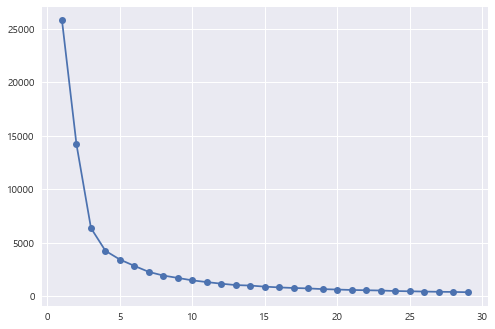

In [282]:
# 라이브러리 불러오기
from sklearn.cluster import KMeans

x = [] # k가 몇개인지
y = [] # 응집도가 몇인지

for k in range(1,30) :
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(data2)
    
    x.append(k)
    y.append(kmeans.inertia_)
    
# 그래프 그리기
plt.plot(x, y, '-o')

k는 3,4가 적당해 보임.

## 2-2 Silhouette 계수

군집타당성지표인 실루엣 점수를 이용한다.  
1에 가까울 수록 적절한 군집화가 되었다고 판단한다.

In [284]:
from sklearn.metrics import silhouette_score

k_range = range(2,10)
best_n = -1
best_silhouette_score = -1

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=200)
    kmeans.fit(data2)
    clusters = kmeans.predict(data2)
    
    score =silhouette_score(data2, clusters)
    print('k:', k, 'score:',score)
    
    if score > best_silhouette_score:
        best_n = k
        best_silhouette_score = score
print('best n:', best_n, 'best_score:' ,best_silhouette_score)

k: 2 score: 0.7795766324959122
k: 3 score: 0.6639502084216448
k: 4 score: 0.5219901103200058
k: 5 score: 0.543700344190533
k: 6 score: 0.5450776682197502
k: 7 score: 0.5042414011199158
k: 8 score: 0.5034608058360294
k: 9 score: 0.458469805394719
best n: 2 best_score: 0.7795766324959122


best k는 2이다. 

# 3. Kmeans Clustering

Text(0.5, 0, 'k=4')

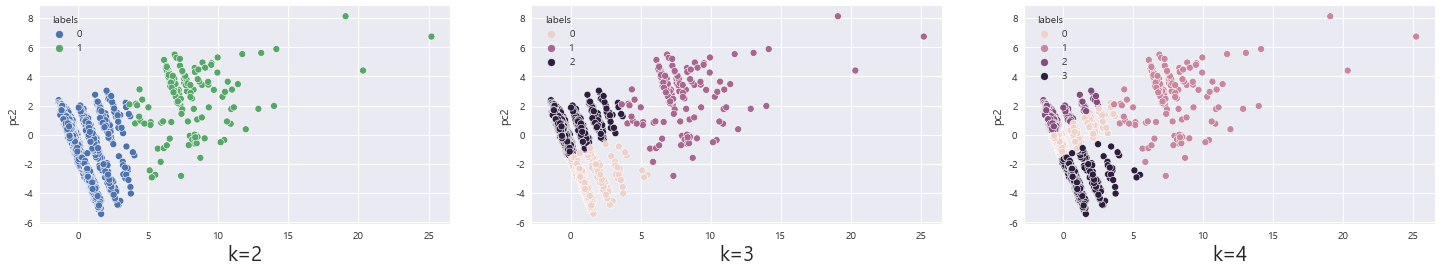

In [285]:
# k=2,3,4 군집화
fig, ax = plt.subplots(ncols=3, figsize=(25,4))

kmeans = KMeans(n_clusters = 2)
kmeans.fit(data2)
data2['labels'] = kmeans.predict(data2)
aa=sns.scatterplot(ax=ax[0], x = 'pc1', y = 'pc2', hue = 'labels', data = data2)
aa.set_xlabel("k=2", fontsize = 20)

kmeans = KMeans(n_clusters = 3)
kmeans.fit(data2)
data2['labels'] = kmeans.predict(data2)
aa=sns.scatterplot(ax=ax[1], x = 'pc1', y = 'pc2', hue = 'labels', data = data2)
aa.set_xlabel("k=3", fontsize = 20)

kmeans = KMeans(n_clusters = 4)
kmeans.fit(data2)
data2['labels'] = kmeans.predict(data2)
aa=sns.scatterplot(ax=ax[2], x = 'pc1', y = 'pc2', hue = 'labels', data = data2)
aa.set_xlabel("k=4", fontsize = 20)

# 4. 클러스터링 해석

In [286]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(data2)
data2['labels'] = kmeans.predict(data2)

In [287]:
# 맨 처음 떼어 두었던 medv 컬럼을 추가합니다.
data2['나쁜습관'] = a
data2['바뀔 수 없는 구강구조'] = b
data2['치아 상황'] = c

data2.head()

,pc1,pc2,labels,나쁜습관,바뀔 수 없는 구강구조,치아 상황
0,-0.282244,-0.259002,1,0,0,2
1,-0.567206,0.356010,0,0,0,0
2,0.027072,-1.328594,1,0,0,3
3,-0.447060,-0.044956,1,1,0,1
4,-0.447060,-0.044956,1,1,0,1


In [288]:
# 시각화를 위해 각 그룹별 값을 따로 변수로 생성

habit_0 = data2[data2['labels']==0]['나쁜습관'].mean()
habit_1 = data2[data2['labels']==1]['나쁜습관'].mean()
habit_2 = data2[data2['labels']==2]['나쁜습관'].mean()
habit_3 = data2[data2['labels']==3]['나쁜습관'].mean()

oral_0 = data2[data2['labels']==0]['바뀔 수 없는 구강구조'].mean()
oral_1 = data2[data2['labels']==1]['바뀔 수 없는 구강구조'].mean()
oral_2 = data2[data2['labels']==2]['바뀔 수 없는 구강구조'].mean()
oral_3 = data2[data2['labels']==3]['바뀔 수 없는 구강구조'].mean()

teeth_0 = data2[data2['labels']==0]['치아 상황'].mean()
teeth_1 = data2[data2['labels']==1]['치아 상황'].mean()
teeth_2 = data2[data2['labels']==2]['치아 상황'].mean()
teeth_3 = data2[data2['labels']==3]['치아 상황'].mean()


Text(0.5, 0, '치아 상황')

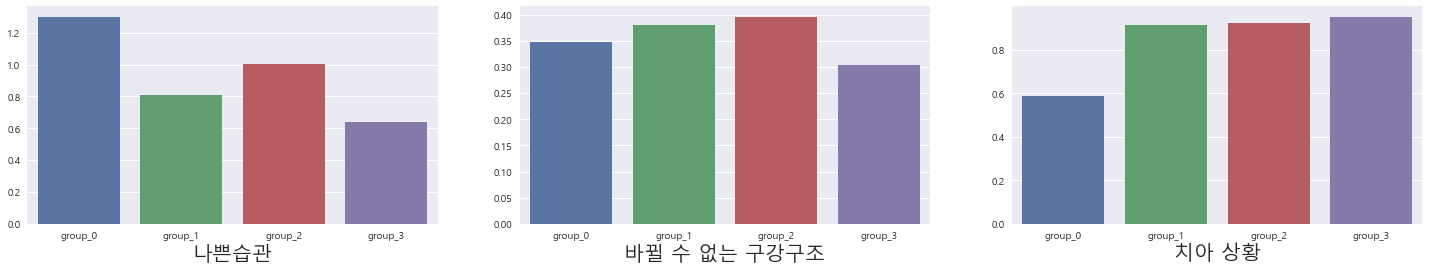

In [289]:
# 그룹별 파생변수 그래프

fig, ax = plt.subplots(ncols=3, figsize=(25,4))

aa = sns.barplot(x = ['group_0','group_1', 'group_2','group_3'], y = [habit_0, habit_1, habit_2, habit_3] , ax=ax[0])
aa.set_xlabel("나쁜습관", fontsize = 20)

aa = sns.barplot(x = ['group_0','group_1', 'group_2','group_3'], y = [oral_0, oral_1, oral_2, oral_3] , ax=ax[1])
aa.set_xlabel('바뀔 수 없는 구강구조', fontsize = 20)

aa = sns.barplot(x = ['group_0','group_1', 'group_2','group_3'], y = [teeth_0, teeth_1, teeth_2, teeth_3] , ax=ax[2])
aa.set_xlabel('치아 상황', fontsize = 20)

In [290]:
import numpy as np
from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

In [291]:
# 레이더차트용 데이터프레임 - 그룹별 파생변수 평균
RC = pd.DataFrame()
RC['habit'] = [habit_0, habit_1, habit_2, habit_3] 
RC['oral'] = [oral_0, oral_1, oral_2, oral_3]
RC['teeth'] = [teeth_0, teeth_1, teeth_2, teeth_3]
RC['group'] = ['group_0','group_1', 'group_2','group_3']
RC

,habit,oral,teeth,group
0,1.301047,0.348691,0.589529,group_0
1,0.810932,0.380064,0.913183,group_1
2,1.006289,0.396226,0.924528,group_2
3,0.641026,0.304274,0.952137,group_3


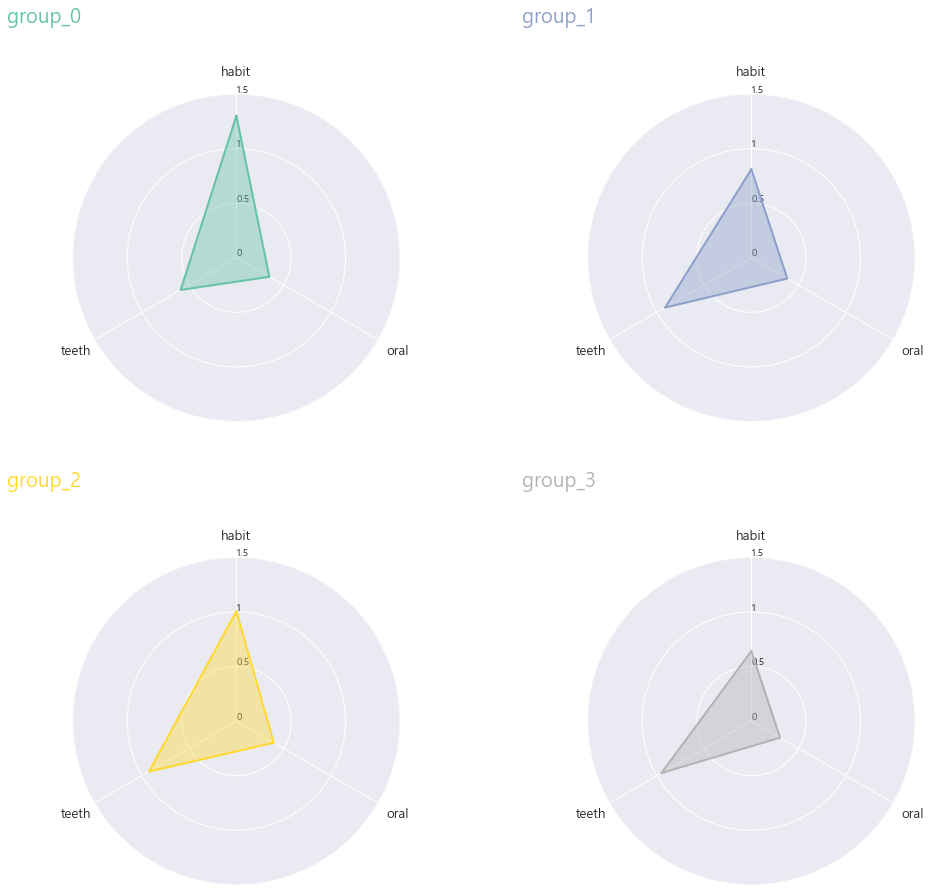

In [292]:
## 레이더 차트 그리기
labels = RC.columns[:3]
num_labels = len(labels)
    
angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)] ## 각 등분점
angles += angles[:1] ## 시작점으로 다시 돌아와야하므로 시작점 추가
    
my_palette = plt.cm.get_cmap("Set2", len(RC.index))
 
fig = plt.figure(figsize=(15,20))
fig.set_facecolor('white')
 
for i, row in RC.iterrows():
    color = my_palette(i)
    data = RC.iloc[i].drop(['group']).tolist()
    data += data[:1]
    
    ax = plt.subplot(3,2,i+1, polar=True)
    ax.set_theta_offset(pi / 2) ## 시작점
    ax.set_theta_direction(-1) ## 그려지는 방향 시계방향
    
    plt.xticks(angles[:-1], labels, fontsize=13) ## x축 눈금 라벨
    ax.tick_params(axis='x', which='major', pad=15) ## x축과 눈금 사이에 여백을 준다.
 
    ax.set_rlabel_position(0) ## y축 각도 설정(degree 단위)
    plt.yticks([0,0.5,1,1.5],['0','0.5','1', '1.5'], fontsize=10) ## y축 눈금 설정
    plt.ylim(0,1.5)
    
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid') ## 레이더 차트 출력
    ax.fill(angles, data, color=color, alpha=0.4) ## 도형 안쪽에 색을 채워준다.
    
    plt.title(RC['group'][i], size=20, color=color,x=-0.2, y=1.2, ha='left') ## 타이틀은 캐릭터 클래스로 한다.
 
plt.tight_layout(pad=5) ## subplot간 패딩 조절
plt.show()

elbow point는 3,4이고, 실루엣 계수는 2이었다.  
K=2,3,4 각각 그려본 결과  
K=4 일때 레이더 차트를 확인해 보니 실제 비즈니스에서 쓰일 수 있는 고객분류가 가장 잘 되는 것으로 보임.